In [134]:
#Runs successfully on MBP 2024 metal_102 conda environment.
import numpy as np
import torch
import torch.nn as nn
import pymc as pm
from pymc.util import get_value_vars_from_user_vars
import arviz as az
import pytensor.tensor as tt
from pytensor import scan
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
# Suppress PyTorch warnings
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Use CPU instead of GPU
print(pm.__version__)

5.12.0


In [135]:
# Define constants
SIZE = 200
T=200
dt=0.1
NUM_SAMPLES = 100
EPOCHS = 100

In [136]:
import pymc as pm
import numpy as np
import torch
from pymc.step_methods.metropolis import Metropolis
from pymc.step_methods.arraystep import ArrayStepShared, ArrayStep, metrop_select
"""
class CustomGANStep(ArrayStepShared):
    def __init__(self, vars=None, model=None, discriminator=None, **kwargs):
        self.model = model or pm.modelcontext(None)
        self.discriminator = discriminator
        
        # Initialize superclass
        super().__init__(vars, shared_globals=kwargs.get('shared_globals', {}))

        # Create mappings between variable names and their indices
        self.var_indices = {var.name: i for i, var in enumerate(self.vars)}
        
        # Initialize step sizes (you may want to tune these)
        self.step_sizes = {var.name: 0.01 for var in self.vars}

    def astep(self, q0):
        # Current parameter values
        current_params = {var.name: q0[i] for i, var in enumerate(self.vars)}
        
        # Propose new parameters
        proposed_params = self.propose(current_params)
        
        # Generate synthetic data with proposed parameters
        synthetic_data = self.generate_synthetic_data(proposed_params)
        
        # Get discriminator score for proposed data
        disc_score = self.get_discriminator_score(synthetic_data)
        
        # Compute acceptance probability
        accept_prob = np.exp(disc_score - self.get_discriminator_score(self.generate_synthetic_data(current_params)))
        
        # Accept or reject
        if np.random.random() < accept_prob:
            return np.array([proposed_params[var.name] for var in self.vars])
        else:
            return q0

    def propose(self, current_params):
        # Simple random walk proposal
        return {name: value + np.random.normal(0, self.step_sizes[name]) 
                for name, value in current_params.items()}

    def generate_synthetic_data(self, params):
        # Implement this method to generate synthetic data using the given parameters
        # This should use your pymc_sim_channel function
        return pymc_sim_channel([params[var.name] for var in self.vars], T, dt, source="torch")

    def get_discriminator_score(self, data):
        # Convert data to appropriate format for your discriminator
        data_tensor = torch.tensor(data).float().unsqueeze(0)  # Add batch dimension
        
        # Get discriminator output
        with torch.no_grad():
            score = self.discriminator(data_tensor).item()
        
        return score"""


class CustomGANStep(ArrayStep):
    def __init__(self, vars=None, model=None, discriminator=None):
        self.model = model or pm.modelcontext(None)
        self.discriminator = discriminator
        
        # Get the actual value variables from the model
        self.vars = get_value_vars_from_user_vars(vars, self.model)
        
        # Define the logp function
        def logp(x):
            for var, value in zip(self.vars, x):
                var.set_value(value)
            return self.model.logp()

        # Initialize superclass
        super().__init__(self.vars, [logp])

        # Create mappings between variable names and their indices
        self.var_indices = {var.name: i for i, var in enumerate(self.vars)}
        
        # Initialize step sizes (you may want to tune these)
        self.step_sizes = {var.name: 0.01 for var in self.vars}

    def astep(self, q0):
        # Current parameter values
        current_params = {var.name: q0[i] for i, var in enumerate(self.vars)}
        
        # Propose new parameters
        proposed_params = self.propose(current_params)
        
        # Generate synthetic data with proposed parameters
        synthetic_data = self.generate_synthetic_data(proposed_params)
        
        # Get discriminator score for proposed data
        disc_score = self.get_discriminator_score(synthetic_data)
        
        # Compute acceptance probability
        accept_prob = np.exp(disc_score - self.get_discriminator_score(self.generate_synthetic_data(current_params)))
        
        # Accept or reject
        if np.random.random() < accept_prob:
            return np.array([proposed_params[var.name] for var in self.vars])
        else:
            return q0

    def propose(self, current_params):
        # Simple random walk proposal
        return {name: value + np.random.normal(0, self.step_sizes[name]) 
                for name, value in current_params.items()}

    def generate_synthetic_data(self, params):
        # Implement this method to generate synthetic data using the given parameters
        # This should use your pymc_sim_channel function
        return pymc_sim_channel([params[var.name] for var in self.vars], T, dt, source="torch")

    def get_discriminator_score(self, data):
        # Convert data to appropriate format for your discriminator
        data_tensor = torch.tensor(data).float().unsqueeze(0)  # Add batch dimension
        
        # Get discriminator output
        with torch.no_grad():
            score = self.discriminator(data_tensor).item()
        
        return score

In [137]:
# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * (SIZE // 4), 1)
        )

    def forward(self, x):
        return self.model(x.permute(0, 2, 1))

In [138]:
# Loss function for the discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output))
    fake_loss = nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

In [139]:
# Create and compile the discriminator
discriminator = Discriminator()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [140]:
import pytensor.tensor as tt
from pytensor.scan import scan
from pytensor.tensor.random.utils import RandomStream
import torch
import numpy as np

def pymc_sim_channel(params, T, dt, source="torch"):
    kc12, kc21, Fnoise, scale, offset, kco1, koc2, ko12, ko21 = params
    eps = 1e-10  # Small constant to avoid zero probabilities
    if source == "pymc":
        zero = tt.constant(0.0)
        one = tt.constant(1.0)
        
        # Convert parameters to PyTensor tensors
        """
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(tt.as_tensor_variable, 
                                                                        [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])

        """
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(lambda x: tt.maximum(tt.as_tensor_variable(x), eps), 
                                                                [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])
        # Create transition matrix
        row1 = tt.stack([1-kc12, kc12, zero, zero])
        row2 = tt.stack([kc21, 1-kc21-kco1, kco1, zero])
        row3 = tt.stack([zero, koc2, 1-koc2-ko12, ko12])
        row4 = tt.stack([zero, zero, ko21, 1-ko21])
        transition_matrix = tt.stack([row1, row2, row3, row4])

        transition_matrix = tt.maximum(transition_matrix, eps)
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_matrix = transition_matrix / row_sums
        
        # Create a RandomStream for managing the RNG
        srng = RandomStream()
        
        # Generate random initial state
        initial_state = srng.categorical(tt.ones(4) / 4, size=(1,))
        
        def step(state, transition_probs):
            new_state = srng.categorical(transition_probs[state[0]], size=(1,))
            return new_state
        
        states, _ = scan(
            fn=step,
            outputs_info=initial_state,
            non_sequences=transition_matrix,
            n_steps=SIZE-1
        )
        
        states = tt.concatenate([initial_state, states.flatten()])
        
        # Convert states to channels
        channels = tt.switch(states < 2, zero, one)
        
        # Generate noise
        noise = srng.normal(0, Fnoise, size=(SIZE,))
        
        # Combine channels and noise
        result = tt.stack([channels, channels * scale + offset + noise], axis=-1)
        
        # Return the PyTensor variable directly
        return result


    else:
        # Convert to PyTorch tensors
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(lambda x: torch.tensor(max(x, eps)), 
                                                                        [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])
        
        # Create transition matrix
        row1 = torch.tensor([1-kc12, kc12, 0, 0])
        row2 = torch.tensor([kc21, 1-kc21-kco1, kco1, 0])
        row3 = torch.tensor([0, koc2, 1-koc2-ko12, ko12])
        row4 = torch.tensor([0, 0, ko21, 1-ko21])
                
        transition_matrix = torch.stack([row1, row2, row3, row4])
        
        # Ensure non-negative values and add small constant
        transition_matrix = torch.clamp(transition_matrix, min=eps)
        
        # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(dim=1, keepdim=True)
        transition_matrix = transition_matrix / row_sums
        
        def transition_fn(state):
            probs = transition_matrix[state]
            return torch.distributions.Categorical(probs=probs).sample()
        
        initial_probs = torch.ones(4) / 4  # Equal probability for all initial states
        initial_distribution = torch.distributions.Categorical(probs=initial_probs)
        
        states = [initial_distribution.sample().item()]
        
        for _ in range(SIZE - 1):
            states.append(transition_fn(states[-1]).item())
        
        channels = torch.tensor(states)
        channels = torch.where(channels < 2, torch.zeros_like(channels), torch.ones_like(channels))
        noise = torch.normal(0, Fnoise, (SIZE,))
        
        res = torch.stack([channels, channels * scale + offset + noise], axis=-1)
        return res

Text(0.5, 1.0, 'torch sim Channel Data')

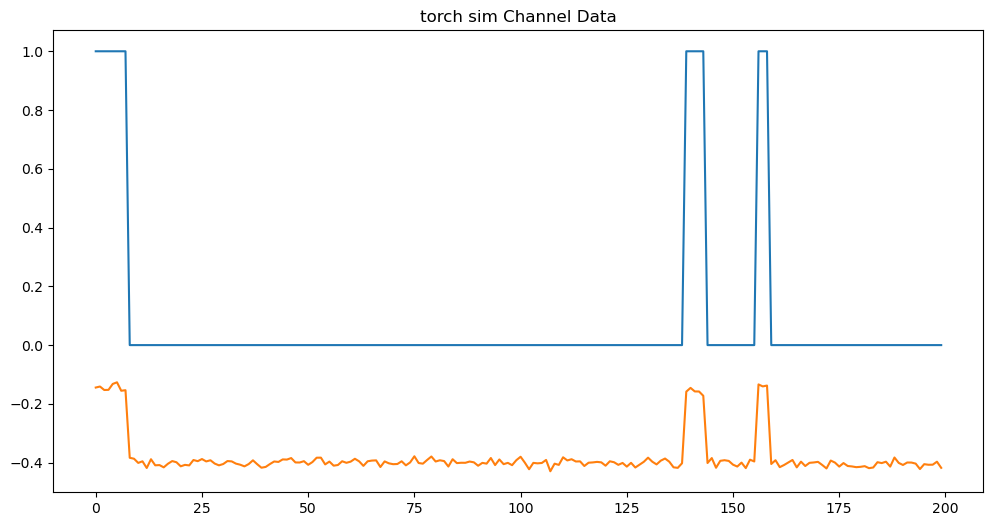

In [141]:
kc12=0.1
kc21=2
Fnoise=0.01
scale=0.25
offset=-0.4
kco1=0.5
kco2=0.25
ko12=1
ko21=2 
orig_params=[kc12,kc21,Fnoise,scale, offset,kco1,kco2,ko12,ko21]
plt.figure(figsize=(12, 6))
plt.plot(pymc_sim_channel(orig_params, T, dt))
plt.title('torch sim Channel Data')

In [142]:
real_data = torch.stack([pymc_sim_channel(orig_params, T, dt) for _ in range(NUM_SAMPLES)], dim=0)

/var/folders/_n/b_grcm9j7pd5hrdkdnkl728m0000gn/T/ipykernel_29797/4035828198.py:42: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_predictive = pm.sample_prior_predictive(samples=1000)
Sampling: [Fnoise, kc12, kc21, kco1, ko12, ko21, koc2, offset, scale]


Model structure:
kc21: TensorVariable
  Potential
kc12: TensorVariable
  Potential
kco1: TensorVariable
  Potential
koc2: TensorVariable
  Potential
ko12: TensorVariable
  Potential
ko21: TensorVariable
  Potential
Fnoise: TensorVariable
  Potential
scale: TensorVariable
  Potential
offset: TensorVariable
  Potential
discriminator_probs: TensorSharedVariable
  Potential
likelihood: TensorVariable
  Potential

Random draw from prior:
kc12: mean = 0.2868, std = 0.1572
koc2: mean = 0.2934, std = 0.1593
kc21: mean = 0.2875, std = 0.1607
kco1: mean = 0.2909, std = 0.1575
Fnoise: mean = 0.7956, std = 0.5905
ko12: mean = 0.2841, std = 0.1604
ko21: mean = 0.2895, std = 0.1618
offset: mean = -0.0589, std = 1.0210
scale: mean = 0.8043, std = 0.6066

Prior distributions:


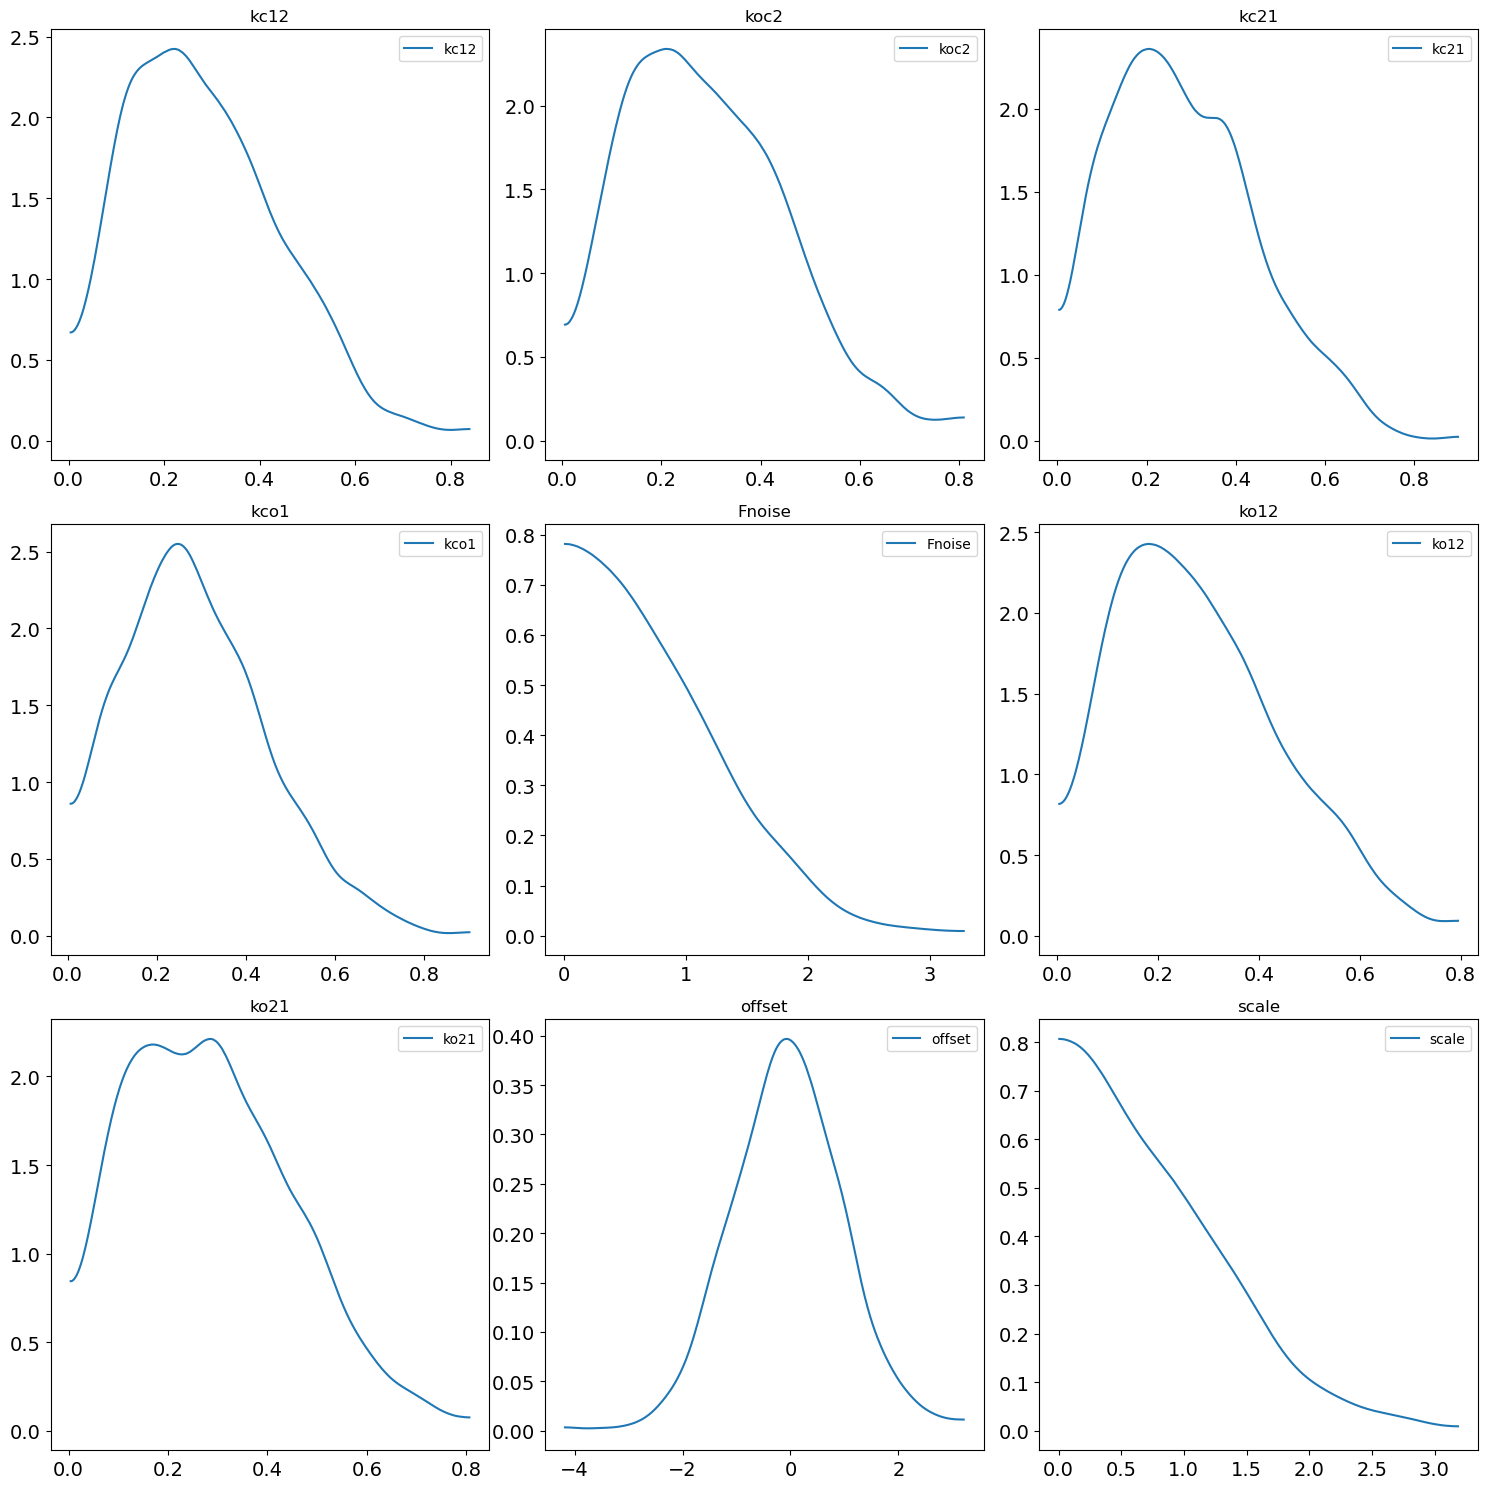


Model created successfully!


In [143]:
import pymc as pm
import pytensor.tensor as tt
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def create_model(T, dt, NUM_SAMPLES):
    with pm.Model() as model:
        # Priors for parameters (using transformed distributions to ensure valid ranges)
        kc21 = pm.Beta('kc21', alpha=2, beta=5)
        kc12 = pm.Beta('kc12', alpha=2, beta=5)
        kco1 = pm.Beta('kco1', alpha=2, beta=5)
        koc2 = pm.Beta('koc2', alpha=2, beta=5)
        ko12 = pm.Beta('ko12', alpha=2, beta=5)
        ko21 = pm.Beta('ko21', alpha=2, beta=5)
        Fnoise = pm.HalfNormal('Fnoise', sigma=1)
        scale = pm.HalfNormal('scale', sigma=1)
        offset = pm.Normal('offset', mu=0, sigma=1)

        # Placeholder for discriminator probabilities
        discriminator_probs = pm.MutableData('discriminator_probs', np.ones(NUM_SAMPLES) * 0.5)

        # Add a small epsilon to avoid log(0) or log(1)
        epsilon = 1e-7
        safe_probs = tt.clip(discriminator_probs, epsilon, 1 - epsilon)

        # Likelihood based on discriminator probabilities
        likelihood = pm.Potential('likelihood', tt.sum(tt.log(safe_probs)))

        # Debugging information
        print("Model structure:")
        for v in model.named_vars.values():
            print(f"{v.name}: {type(v).__name__}")
            if hasattr(v, 'distribution'):
                print(f"  Distribution: {type(v.distribution).__name__}")
            elif hasattr(v, 'tag'):
                print(f"  Potential")
            else:
                print(f"  Type: {type(v)}")

        print("\nRandom draw from prior:")
        prior_predictive = pm.sample_prior_predictive(samples=1000)
        for var_name, value in prior_predictive.prior.items():
            if var_name != 'discriminator_probs':
                print(f"{var_name}: mean = {value.mean().item():.4f}, std = {value.std().item():.4f}")

        print("\nPrior distributions:")
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        axes = axes.flatten()
        for i, (var_name, value) in enumerate(prior_predictive.prior.items()):
            if var_name != 'discriminator_probs':
                az.plot_dist(value, ax=axes[i], label=var_name)
                axes[i].set_title(var_name)
                axes[i].legend()
        plt.tight_layout()
        plt.show()

    return model

# Usage
model = create_model(T, dt, NUM_SAMPLES)
print("\nModel created successfully!")

In [144]:
"""with pm.Model() as model:
    # Priors (as before)
    kc21 = pm.Beta('kc21', alpha=2, beta=5)
    kc12 = pm.Beta('kc12', alpha=2, beta=5)
    kco1 = pm.Beta('kco1', alpha=2, beta=5)
    koc2 = pm.Beta('koc2', alpha=2, beta=5)
    ko12 = pm.Beta('ko12', alpha=2, beta=5)
    ko21 = pm.Beta('ko21', alpha=2, beta=5)
    Fnoise = pm.HalfNormal('Fnoise', sigma=1)
    scale = pm.HalfNormal('scale', sigma=1)
    offset = pm.Normal('offset', mu=0, sigma=1)
    
    # Generate synthetic data
    synthetic_data = pm.Deterministic('synthetic_data', 
                                      pymc_sim_channel([kc12, kc21, Fnoise, scale, offset, kco1, koc2, ko12, ko21], T, dt, source="pymc"))

    # Placeholder for discriminator probabilities
    discriminator_probs = pm.MutableData('discriminator_probs', np.zeros(NUM_SAMPLES))

    # Likelihood based on discriminator probabilities
    pm.Potential('likelihood', tt.sum(tt.log(discriminator_probs)))"""


'with pm.Model() as model:\n    # Priors (as before)\n    kc21 = pm.Beta(\'kc21\', alpha=2, beta=5)\n    kc12 = pm.Beta(\'kc12\', alpha=2, beta=5)\n    kco1 = pm.Beta(\'kco1\', alpha=2, beta=5)\n    koc2 = pm.Beta(\'koc2\', alpha=2, beta=5)\n    ko12 = pm.Beta(\'ko12\', alpha=2, beta=5)\n    ko21 = pm.Beta(\'ko21\', alpha=2, beta=5)\n    Fnoise = pm.HalfNormal(\'Fnoise\', sigma=1)\n    scale = pm.HalfNormal(\'scale\', sigma=1)\n    offset = pm.Normal(\'offset\', mu=0, sigma=1)\n    \n    # Generate synthetic data\n    synthetic_data = pm.Deterministic(\'synthetic_data\', \n                                      pymc_sim_channel([kc12, kc21, Fnoise, scale, offset, kco1, koc2, ko12, ko21], T, dt, source="pymc"))\n\n    # Placeholder for discriminator probabilities\n    discriminator_probs = pm.MutableData(\'discriminator_probs\', np.zeros(NUM_SAMPLES))\n\n    # Likelihood based on discriminator probabilities\n    pm.Potential(\'likelihood\', tt.sum(tt.log(discriminator_probs)))'

In [145]:

def generate_synthetic_data(trace, num_samples, T, dt):
    # Get the last sample from the trace
    last_sample = {var: trace.posterior[var].values[:, -1, ...].flatten() 
                   for var in trace.posterior.data_vars 
                   if var != 'discriminator_probs'}
    
    synthetic_data = []
    for _ in range(num_samples):
        # Randomly select a set of parameters from the last samples
        params = {
            'kc12': np.random.choice(last_sample['kc12']),
            'kc21': np.random.choice(last_sample['kc21']),
            'Fnoise': np.random.choice(last_sample['Fnoise']),
            'scale': np.random.choice(last_sample['scale']),
            'offset': np.random.choice(last_sample['offset']),
            'kco1': np.random.choice(last_sample['kco1']),
            'koc2': np.random.choice(last_sample['koc2']),
            'ko12': np.random.choice(last_sample['ko12']),
            'ko21': np.random.choice(last_sample['ko21'])
        }
        
        # Generate a single synthetic data sample
        sample = pymc_sim_channel([params['kc12'], params['kc21'], params['Fnoise'], 
                                   params['scale'], params['offset'], params['kco1'], 
                                   params['koc2'], params['ko12'], params['ko21']], 
                                  T, dt, source="torch")
        
        synthetic_data.append(sample)
    
    # Stack all samples into a single tensor
    return torch.stack(synthetic_data).float()

In [ ]:
from tqdm import tqdm
import pymc as pm
import torch

def train_gan_mcmc_hybrid(model, discriminator, real_data, num_epochs, num_samples, T, dt):
    trace = None  # Initialize trace as None
    for epoch in tqdm(range(num_epochs)):
        #clear_output(wait=True)
        try:
            # If it's the first epoch or we want to reinitialize trace periodically
            if trace is None or epoch % 10 == 0:  # Reinitialize every 10 epochs, adjust as needed
                with model:
                    # Initialize with a short run of standard MCMC
                    trace = pm.sample(500, tune=50, chains=4)
            
            # Generate synthetic data using current trace
            synthetic_data = generate_synthetic_data(trace, num_samples, T, dt)
            
            # Train discriminator
            real_output = discriminator(real_data)
            fake_output = discriminator(synthetic_data)
            disc_loss = discriminator_loss(real_output, fake_output)
            discriminator_optimizer.zero_grad()
            disc_loss.backward()
            discriminator_optimizer.step()
            
            # Get updated discriminator probabilities
            with torch.no_grad():
                disc_probs = torch.sigmoid(discriminator(synthetic_data)).reshape(-1) 
            
            # Update the model with new discriminator probabilities
            with model:
                pm.set_data({'discriminator_probs': disc_probs})
            
            # Perform MCMC with custom step method
            custom_step = CustomGANStep(
                vars=['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21'],
                model=model,
                discriminator=discriminator
            )
                        
            with model:
                if epoch < 2:
                    trace = pm.sample(500, tune=100, chains=4)
                else:
                    trace = pm.sample(500, step=[custom_step], chains=1)
            
            # Optional: Print some diagnostics
            print(f"Epoch {epoch+1}/{num_epochs}, Disc Loss: {disc_loss.item():.4f}")
        
        except Exception as e:
            print(f"Error in epoch {epoch+1}: {str(e)}")
            # You might want to add more detailed error handling here
    return trace

# Usage
final_trace = train_gan_mcmc_hybrid(model, discriminator, real_data, 
                                    num_epochs=EPOCHS, num_samples=NUM_SAMPLES, T=T, dt=dt)

  0%|                                                                                                                           | 0/100 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]


Sampling 4 chains for 50 tune and 500 draw iterations (200 + 2_000 draws total) took 1 seconds.
  1%|█▏                                                                                                                 | 1/100 [00:04<07:27,  4.52s/it]

Error in epoch 1: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


  2%|██▎                                                                                                                | 2/100 [00:05<03:38,  2.23s/it]

Error in epoch 2: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


  3%|███▍                                                                                                               | 3/100 [00:05<02:25,  1.50s/it]

Error in epoch 3: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


  4%|████▌                                                                                                              | 4/100 [00:06<01:50,  1.15s/it]

Error in epoch 4: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


  5%|█████▊                                                                                                             | 5/100 [00:07<01:31,  1.03it/s]

Error in epoch 5: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


  6%|██████▉                                                                                                            | 6/100 [00:07<01:20,  1.17it/s]

Error in epoch 6: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


  7%|████████                                                                                                           | 7/100 [00:08<01:13,  1.27it/s]

Error in epoch 7: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


  8%|█████████▏                                                                                                         | 8/100 [00:08<01:07,  1.36it/s]

Error in epoch 8: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


  9%|██████████▎                                                                                                        | 9/100 [00:09<01:03,  1.43it/s]

Error in epoch 9: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 10%|███████████▍                                                                                                      | 10/100 [00:10<01:01,  1.47it/s]

Error in epoch 10: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]


Sampling 4 chains for 50 tune and 500 draw iterations (200 + 2_000 draws total) took 1 seconds.
 11%|████████████▌                                                                                                     | 11/100 [00:13<02:23,  1.61s/it]

Error in epoch 11: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 12%|█████████████▋                                                                                                    | 12/100 [00:14<01:55,  1.31s/it]

Error in epoch 12: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 13%|██████████████▊                                                                                                   | 13/100 [00:15<01:36,  1.11s/it]

Error in epoch 13: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 14%|███████████████▉                                                                                                  | 14/100 [00:15<01:23,  1.03it/s]

Error in epoch 14: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 15%|█████████████████                                                                                                 | 15/100 [00:16<01:13,  1.15it/s]

Error in epoch 15: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 16%|██████████████████▏                                                                                               | 16/100 [00:17<01:07,  1.25it/s]

Error in epoch 16: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 17%|███████████████████▍                                                                                              | 17/100 [00:17<01:02,  1.34it/s]

Error in epoch 17: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 18%|████████████████████▌                                                                                             | 18/100 [00:18<00:58,  1.40it/s]

Error in epoch 18: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 19%|█████████████████████▋                                                                                            | 19/100 [00:19<00:55,  1.46it/s]

Error in epoch 19: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 20%|██████████████████████▊                                                                                           | 20/100 [00:19<00:53,  1.49it/s]

Error in epoch 20: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]


Sampling 4 chains for 50 tune and 500 draw iterations (200 + 2_000 draws total) took 1 seconds.
 21%|███████████████████████▉                                                                                          | 21/100 [00:24<02:29,  1.89s/it]

Error in epoch 21: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 22%|█████████████████████████                                                                                         | 22/100 [00:25<01:57,  1.51s/it]

Error in epoch 22: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 23%|██████████████████████████▏                                                                                       | 23/100 [00:25<01:35,  1.25s/it]

Error in epoch 23: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 24%|███████████████████████████▎                                                                                      | 24/100 [00:26<01:21,  1.07s/it]

Error in epoch 24: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 25%|████████████████████████████▌                                                                                     | 25/100 [00:26<01:10,  1.06it/s]

Error in epoch 25: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 26%|█████████████████████████████▋                                                                                    | 26/100 [00:27<01:02,  1.18it/s]

Error in epoch 26: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 27%|██████████████████████████████▊                                                                                   | 27/100 [00:28<00:57,  1.27it/s]

Error in epoch 27: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 28%|███████████████████████████████▉                                                                                  | 28/100 [00:28<00:53,  1.35it/s]

Error in epoch 28: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 29%|█████████████████████████████████                                                                                 | 29/100 [00:29<00:50,  1.41it/s]

Error in epoch 29: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 30%|██████████████████████████████████▏                                                                               | 30/100 [00:30<00:47,  1.46it/s]

Error in epoch 30: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]


Sampling 4 chains for 50 tune and 500 draw iterations (200 + 2_000 draws total) took 0 seconds.
 31%|███████████████████████████████████▎                                                                              | 31/100 [00:34<02:08,  1.86s/it]

Error in epoch 31: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 32%|████████████████████████████████████▍                                                                             | 32/100 [00:35<01:42,  1.51s/it]

Error in epoch 32: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 33%|█████████████████████████████████████▌                                                                            | 33/100 [00:36<01:24,  1.26s/it]

Error in epoch 33: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 34%|██████████████████████████████████████▊                                                                           | 34/100 [00:36<01:12,  1.09s/it]

Error in epoch 34: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 35%|███████████████████████████████████████▉                                                                          | 35/100 [00:37<01:02,  1.04it/s]

Error in epoch 35: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 36%|█████████████████████████████████████████                                                                         | 36/100 [00:38<00:55,  1.15it/s]

Error in epoch 36: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 37%|██████████████████████████████████████████▏                                                                       | 37/100 [00:38<00:50,  1.24it/s]

Error in epoch 37: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 38%|███████████████████████████████████████████▎                                                                      | 38/100 [00:39<00:47,  1.31it/s]

Error in epoch 38: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 39%|████████████████████████████████████████████▍                                                                     | 39/100 [00:40<00:44,  1.36it/s]

Error in epoch 39: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 40%|█████████████████████████████████████████████▌                                                                    | 40/100 [00:40<00:42,  1.41it/s]

Error in epoch 40: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]


Sampling 4 chains for 50 tune and 500 draw iterations (200 + 2_000 draws total) took 0 seconds.
 41%|██████████████████████████████████████████████▋                                                                   | 41/100 [00:45<01:51,  1.89s/it]

Error in epoch 41: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 42%|███████████████████████████████████████████████▉                                                                  | 42/100 [00:46<01:27,  1.51s/it]

Error in epoch 42: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 43%|█████████████████████████████████████████████████                                                                 | 43/100 [00:46<01:11,  1.25s/it]

Error in epoch 43: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 44%|██████████████████████████████████████████████████▏                                                               | 44/100 [00:47<01:00,  1.08s/it]

Error in epoch 44: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 45%|███████████████████████████████████████████████████▎                                                              | 45/100 [00:47<00:52,  1.05it/s]

Error in epoch 45: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 46%|████████████████████████████████████████████████████▍                                                             | 46/100 [00:48<00:46,  1.15it/s]

Error in epoch 46: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 47%|█████████████████████████████████████████████████████▌                                                            | 47/100 [00:49<00:42,  1.25it/s]

Error in epoch 47: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 48%|██████████████████████████████████████████████████████▋                                                           | 48/100 [00:49<00:39,  1.32it/s]

Error in epoch 48: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 49%|███████████████████████████████████████████████████████▊                                                          | 49/100 [00:50<00:36,  1.38it/s]

Error in epoch 49: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 50%|█████████████████████████████████████████████████████████                                                         | 50/100 [00:51<00:34,  1.43it/s]

Error in epoch 50: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]


Sampling 4 chains for 50 tune and 500 draw iterations (200 + 2_000 draws total) took 1 seconds.
 51%|██████████████████████████████████████████████████████████▏                                                       | 51/100 [00:55<01:20,  1.64s/it]

Error in epoch 51: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 52%|███████████████████████████████████████████████████████████▎                                                      | 52/100 [00:55<01:04,  1.35s/it]

Error in epoch 52: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 53%|████████████████████████████████████████████████████████████▍                                                     | 53/100 [00:56<00:53,  1.14s/it]

Error in epoch 53: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 54%|█████████████████████████████████████████████████████████████▌                                                    | 54/100 [00:57<00:45,  1.00it/s]

Error in epoch 54: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 55%|██████████████████████████████████████████████████████████████▋                                                   | 55/100 [00:57<00:40,  1.11it/s]

Error in epoch 55: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 56%|███████████████████████████████████████████████████████████████▊                                                  | 56/100 [00:58<00:36,  1.21it/s]

Error in epoch 56: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 57%|████████████████████████████████████████████████████████████████▉                                                 | 57/100 [00:59<00:33,  1.29it/s]

Error in epoch 57: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 58%|██████████████████████████████████████████████████████████████████                                                | 58/100 [00:59<00:31,  1.35it/s]

Error in epoch 58: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 59%|███████████████████████████████████████████████████████████████████▎                                              | 59/100 [01:00<00:29,  1.41it/s]

Error in epoch 59: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 60%|████████████████████████████████████████████████████████████████████▍                                             | 60/100 [01:00<00:27,  1.46it/s]

Error in epoch 60: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]


Sampling 4 chains for 50 tune and 500 draw iterations (200 + 2_000 draws total) took 0 seconds.
 61%|█████████████████████████████████████████████████████████████████████▌                                            | 61/100 [01:05<01:14,  1.92s/it]

Error in epoch 61: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 62%|██████████████████████████████████████████████████████████████████████▋                                           | 62/100 [01:06<00:58,  1.54s/it]

Error in epoch 62: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 63%|███████████████████████████████████████████████████████████████████████▊                                          | 63/100 [01:07<00:47,  1.27s/it]

Error in epoch 63: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 64%|████████████████████████████████████████████████████████████████████████▉                                         | 64/100 [01:07<00:39,  1.09s/it]

Error in epoch 64: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 65%|██████████████████████████████████████████████████████████████████████████                                        | 65/100 [01:08<00:33,  1.04it/s]

Error in epoch 65: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 66%|███████████████████████████████████████████████████████████████████████████▏                                      | 66/100 [01:09<00:29,  1.16it/s]

Error in epoch 66: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 67%|████████████████████████████████████████████████████████████████████████████▍                                     | 67/100 [01:09<00:26,  1.25it/s]

Error in epoch 67: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 68%|█████████████████████████████████████████████████████████████████████████████▌                                    | 68/100 [01:10<00:24,  1.33it/s]

Error in epoch 68: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 69%|██████████████████████████████████████████████████████████████████████████████▋                                   | 69/100 [01:10<00:22,  1.40it/s]

Error in epoch 69: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 70/100 [01:11<00:20,  1.45it/s]

Error in epoch 70: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]


Sampling 4 chains for 50 tune and 500 draw iterations (200 + 2_000 draws total) took 0 seconds.
 71%|████████████████████████████████████████████████████████████████████████████████▉                                 | 71/100 [01:16<00:53,  1.86s/it]

Error in epoch 71: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 72%|██████████████████████████████████████████████████████████████████████████████████                                | 72/100 [01:16<00:41,  1.49s/it]

Error in epoch 72: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 73%|███████████████████████████████████████████████████████████████████████████████████▏                              | 73/100 [01:17<00:33,  1.24s/it]

Error in epoch 73: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 74%|████████████████████████████████████████████████████████████████████████████████████▎                             | 74/100 [01:18<00:27,  1.07s/it]

Error in epoch 74: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 75/100 [01:18<00:23,  1.06it/s]

Error in epoch 75: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 76%|██████████████████████████████████████████████████████████████████████████████████████▋                           | 76/100 [01:19<00:20,  1.17it/s]

Error in epoch 76: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 77%|███████████████████████████████████████████████████████████████████████████████████████▊                          | 77/100 [01:20<00:18,  1.27it/s]

Error in epoch 77: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 78%|████████████████████████████████████████████████████████████████████████████████████████▉                         | 78/100 [01:20<00:16,  1.35it/s]

Error in epoch 78: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 79%|██████████████████████████████████████████████████████████████████████████████████████████                        | 79/100 [01:21<00:14,  1.41it/s]

Error in epoch 79: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 80/100 [01:21<00:13,  1.46it/s]

Error in epoch 80: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]


Sampling 4 chains for 50 tune and 500 draw iterations (200 + 2_000 draws total) took 0 seconds.
 81%|████████████████████████████████████████████████████████████████████████████████████████████▎                     | 81/100 [01:26<00:35,  1.87s/it]

Error in epoch 81: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▍                    | 82/100 [01:27<00:27,  1.50s/it]

Error in epoch 82: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▌                   | 83/100 [01:27<00:21,  1.25s/it]

Error in epoch 83: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 84%|███████████████████████████████████████████████████████████████████████████████████████████████▊                  | 84/100 [01:28<00:17,  1.06s/it]

Error in epoch 84: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 85/100 [01:29<00:14,  1.07it/s]

Error in epoch 85: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████                | 86/100 [01:29<00:11,  1.18it/s]

Error in epoch 86: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▏              | 87/100 [01:30<00:10,  1.27it/s]

Error in epoch 87: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 88/100 [01:31<00:08,  1.35it/s]

Error in epoch 88: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 89/100 [01:31<00:07,  1.41it/s]

Error in epoch 89: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 90/100 [01:32<00:06,  1.46it/s]

Error in epoch 90: The following variables are not random variables in the model: ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]


Sampling 4 chains for 50 tune and 500 draw iterations (200 + 2_000 draws total) took 0 seconds.
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 91/100 [01:36<00:14,  1.59s/it]